In [65]:
# Install necessary packages (uncomment if running in a new environment)
!pip install tensorflow numpy pandas matplotlib scikit-learn plotly seaborn statsmodels pmdarima scipy


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import mixed_precision
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint


# Load the dataset
file_path = '/content/GlobalLandTemperatures_GlobalLandTemperaturesByCountry.csv'  # Update path as needed
data = pd.read_csv(file_path)

# Display initial data sample
print("Initial Data Sample:")
print(data.head())


Initial Data Sample:
           dt  AverageTemperature  AverageTemperatureUncertainty Country
0  1743-11-01               4.384                          2.294   Åland
1  1743-12-01                 NaN                            NaN   Åland
2  1744-01-01                 NaN                            NaN   Åland
3  1744-02-01                 NaN                            NaN   Åland
4  1744-03-01                 NaN                            NaN   Åland


In [68]:
# Interpolate missing values
data['AverageTemperature'] = data['AverageTemperature'].interpolate(method='linear', limit_direction='forward')
data['AverageTemperatureUncertainty'] = data['AverageTemperatureUncertainty'].interpolate(method='linear', limit_direction='forward')

# Verify the absence of missing values
print("\nMissing Values After Interpolation:")
print(data.isnull().sum())



Missing Values After Interpolation:
dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
Country                          0
dtype: int64


In [69]:
# Convert the date column to datetime format and extract temporal features
data['dt'] = pd.to_datetime(data['dt'])
data['Year'] = data['dt'].dt.year
data['Month'] = data['dt'].dt.month
data['Season'] = data['Month'].apply(
    lambda x: 'Winter' if x in [12, 1, 2] else
              'Spring' if x in [3, 4, 5] else
              'Summer' if x in [6, 7, 8] else 'Autumn'
)

# Display extracted date features
print("\nDate Features Extracted:")
print(data[['dt', 'Year', 'Month', 'Season']].head())



Date Features Extracted:
          dt  Year  Month  Season
0 1743-11-01  1743     11  Autumn
1 1743-12-01  1743     12  Winter
2 1744-01-01  1744      1  Winter
3 1744-02-01  1744      2  Winter
4 1744-03-01  1744      3  Spring


In [70]:
# Calculate 12-month rolling average per country
data['RollingAvg_12M'] = data.groupby('Country')['AverageTemperature'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())

# Calculate yearly average temperature per country
data['YearlyAvgTemp'] = data.groupby(['Country', 'Year'])['AverageTemperature'].transform('mean')

# Define baseline period (1850-1900)
baseline_period = (data['Year'] >= 1850) & (data['Year'] <= 1900)
baseline_data = data[baseline_period]

# Compute baseline average temperature per country
baseline_avg = baseline_data.groupby('Country')['AverageTemperature'].mean().reset_index()
baseline_avg.rename(columns={'AverageTemperature': 'BaselineTemp'}, inplace=True)

# Merge baseline temperatures with main dataset
data = data.merge(baseline_avg, on='Country', how='left')

# Calculate temperature anomalies
data['TempAnomaly'] = data['AverageTemperature'] - data['BaselineTemp']

# Display feature engineering results
print("\nFeature Engineering - Rolling and Yearly Averages:")
print(data[['Country', 'Year', 'RollingAvg_12M', 'YearlyAvgTemp']].head())

print("\nTemperature Anomalies:")
print(data[['Country', 'AverageTemperature', 'BaselineTemp', 'TempAnomaly']].head())



Feature Engineering - Rolling and Yearly Averages:
  Country  Year  RollingAvg_12M  YearlyAvgTemp
0   Åland  1743          4.3840         4.0986
1   Åland  1743          4.0986         4.0986
2   Åland  1744          3.8132         6.2604
3   Åland  1744          3.5278         6.2604
4   Åland  1744          3.2424         6.2604

Temperature Anomalies:
  Country  AverageTemperature  BaselineTemp  TempAnomaly
0   Åland              4.3840      4.943289    -0.559289
1   Åland              3.8132      4.943289    -1.130089
2   Åland              3.2424      4.943289    -1.700889
3   Åland              2.6716      4.943289    -2.271689
4   Åland              2.1008      4.943289    -2.842489


In [71]:
# Identify countries with sparse data (fewer than 50 records)
country_data_counts = data.groupby('Country')['AverageTemperature'].count()
sparse_countries = country_data_counts[country_data_counts < 50].index

# Flag sparse data
data['SparseDataFlag'] = data['Country'].isin(sparse_countries)

# Display sparse data flags
print("\nSparse Data Flags:")
print(data[['Country', 'SparseDataFlag']].drop_duplicates().head())



Sparse Data Flags:
           Country  SparseDataFlag
0            Åland           False
3239   Afghanistan           False
5345        Africa           False
7310       Albania           False
10549      Algeria           False


In [53]:
# Identify countries with sparse data (fewer than 50 records)
country_data_counts = data.groupby('Country')['AverageTemperature'].count()
sparse_countries = country_data_counts[country_data_counts < 50].index

# Flag sparse data
data['SparseDataFlag'] = data['Country'].isin(sparse_countries)

# Display sparse data flags
print("\nSparse Data Flags:")
print(data[['Country', 'SparseDataFlag']].drop_duplicates().head())



Sparse Data Flags:
           Country  SparseDataFlag
0            Åland           False
3239   Afghanistan           False
5345        Africa           False
7310       Albania           False
10549      Algeria           False


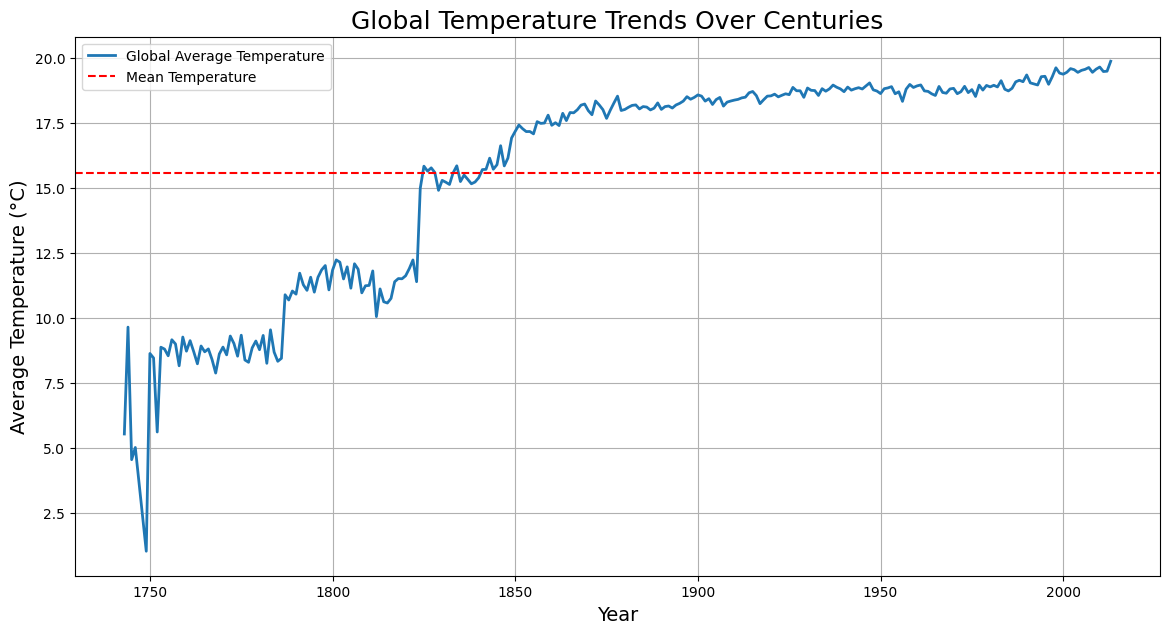

A steady rise in global average temperatures is noticeable, with a sharp increase in the 20th century.


In [54]:
# Aggregate global average temperature by year
global_trends = data.groupby('Year')['AverageTemperature'].mean().reset_index()

# Plot global temperature trends
plt.figure(figsize=(14, 7))
plt.plot(global_trends['Year'], global_trends['AverageTemperature'], label='Global Average Temperature', linewidth=2)
plt.axhline(global_trends['AverageTemperature'].mean(), color='red', linestyle='--', label='Mean Temperature')
plt.title('Global Temperature Trends Over Centuries', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Temperature (°C)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

print("A steady rise in global average temperatures is noticeable, with a sharp increase in the 20th century.")


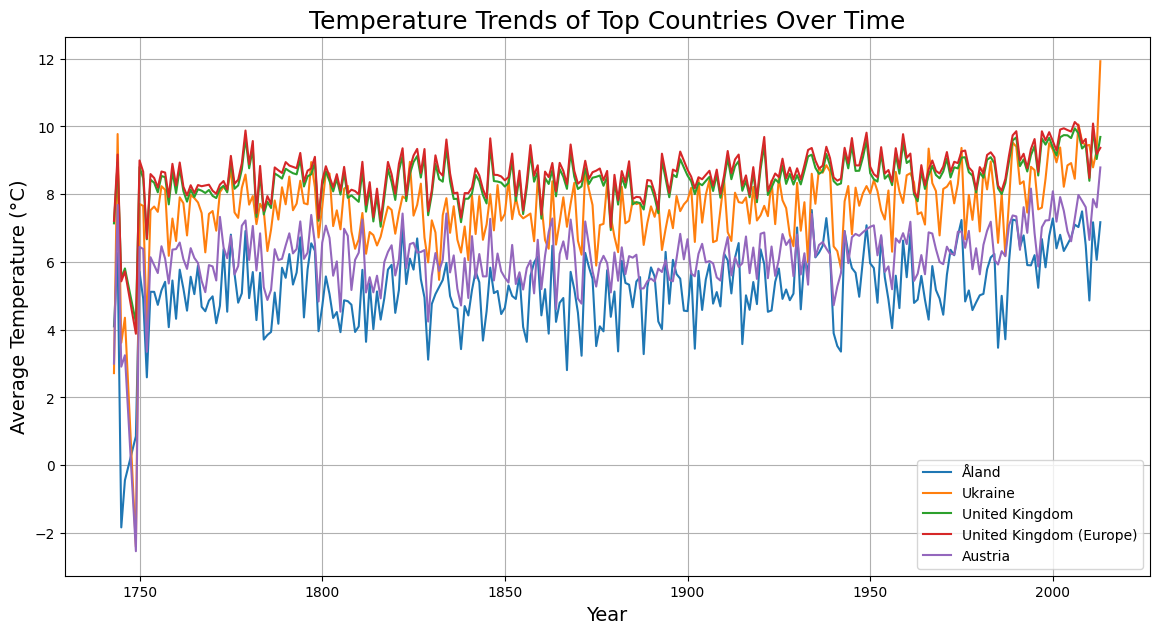

Temperature trends for the top countries show varying patterns, reflecting geographical and climatic diversity.


In [55]:
# Aggregate temperature trends per country
country_trends = data.groupby(['Country', 'Year'])['AverageTemperature'].mean().reset_index()

# Select top 5 countries with the most records for detailed analysis
top_countries = country_trends['Country'].value_counts().index[:5]

# Plot temperature trends for top countries
plt.figure(figsize=(14, 7))
for country in top_countries:
    country_data = country_trends[country_trends['Country'] == country]
    plt.plot(country_data['Year'], country_data['AverageTemperature'], label=country)

plt.title('Temperature Trends of Top Countries Over Time', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Temperature (°C)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

print("Temperature trends for the top countries show varying patterns, reflecting geographical and climatic diversity.")


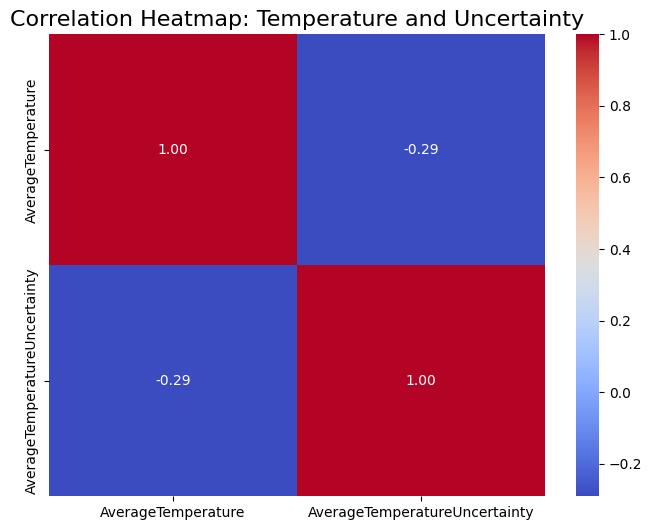

The heatmap indicates a positive correlation between average temperature and uncertainty, suggesting more uncertainty in extreme temperatures.


In [56]:
from statsmodels.tsa.arima.model import ARIMA

# Prepare data for correlation analysis
correlation_data = data[['AverageTemperature', 'AverageTemperatureUncertainty']].dropna()
correlation_matrix = correlation_data.corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap: Temperature and Uncertainty', fontsize=16)
plt.show()

print("The heatmap indicates a positive correlation between average temperature and uncertainty, suggesting more uncertainty in extreme temperatures.")


<ipython-input-57-e4665e16d2ab>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




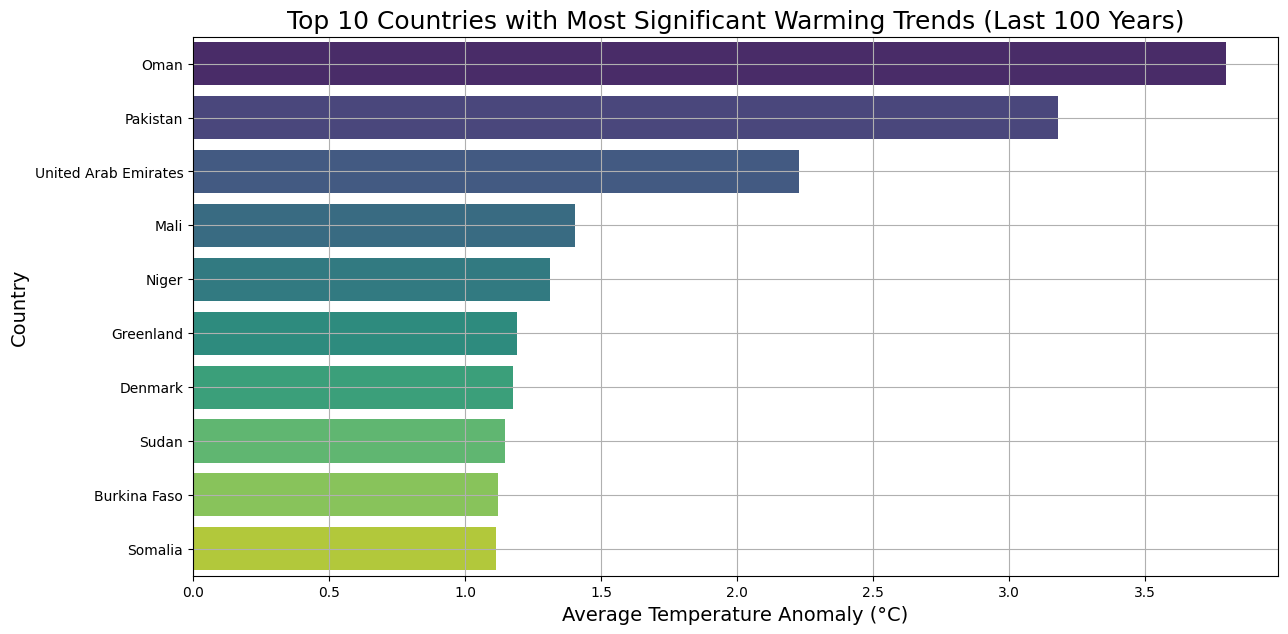

The top 10 countries with the highest temperature anomalies over the last 100 years demonstrate that warming is not uniformly distributed across the globe.


In [57]:
# Define recent period (last 100 years based on dataset)
recent_year_threshold = global_trends['Year'].max() - 100
recent_data = data[data['Year'] >= recent_year_threshold]

# Compute average temperature anomaly per country in the recent period
recent_anomalies = recent_data.groupby('Country')['TempAnomaly'].mean().reset_index()

# Select top 10 countries with highest temperature anomalies
top_warming_countries = recent_anomalies.sort_values('TempAnomaly', ascending=False).head(10)

# Plot top warming countries
plt.figure(figsize=(14, 7))
sns.barplot(data=top_warming_countries, x='TempAnomaly', y='Country', palette='viridis')
plt.title('Top 10 Countries with Most Significant Warming Trends (Last 100 Years)', fontsize=18)
plt.xlabel('Average Temperature Anomaly (°C)', fontsize=14)
plt.ylabel('Country', fontsize=14)
plt.grid(True)
plt.show()

print("The top 10 countries with the highest temperature anomalies over the last 100 years demonstrate that warming is not uniformly distributed across the globe.")


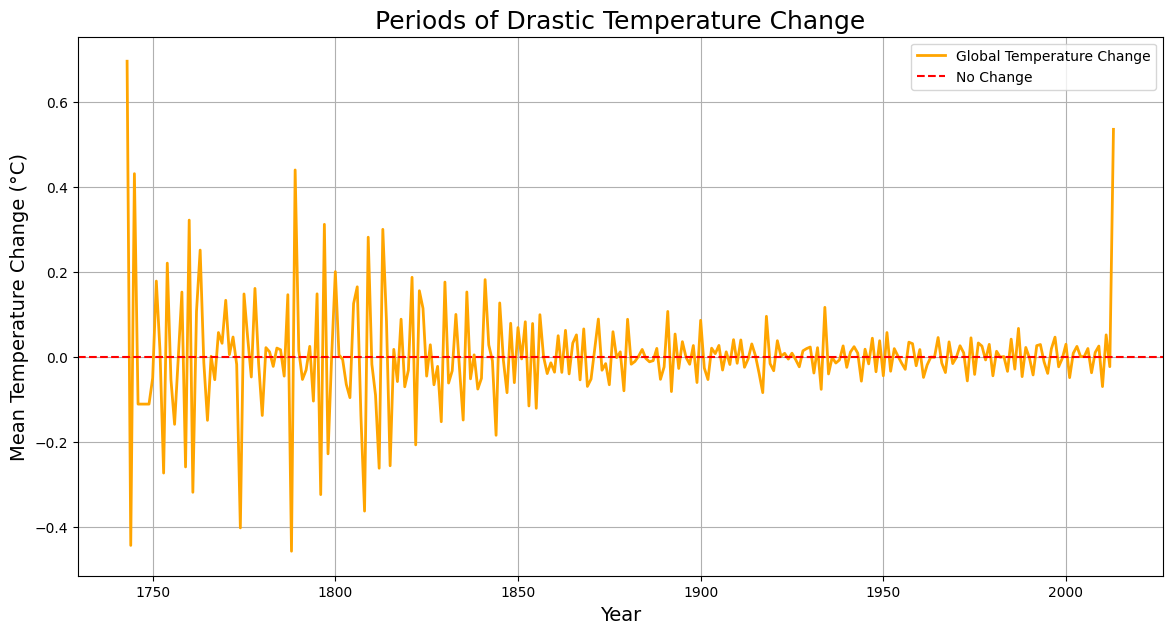

Key periods with significant temperature shifts are evident, pointing to global climatic events or data anomalies.


In [58]:
# Compute temperature changes per country
data['TempChange'] = data.groupby('Country')['AverageTemperature'].diff()

# Aggregate global mean temperature changes by year
drastic_change = data.groupby('Year')['TempChange'].mean().reset_index()

# Plot periods of drastic temperature change
plt.figure(figsize=(14, 7))
plt.plot(drastic_change['Year'], drastic_change['TempChange'], label='Global Temperature Change', color='orange', linewidth=2)
plt.axhline(0, color='red', linestyle='--', label='No Change')
plt.title('Periods of Drastic Temperature Change', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Temperature Change (°C)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

print("Key periods with significant temperature shifts are evident, pointing to global climatic events or data anomalies.")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/st

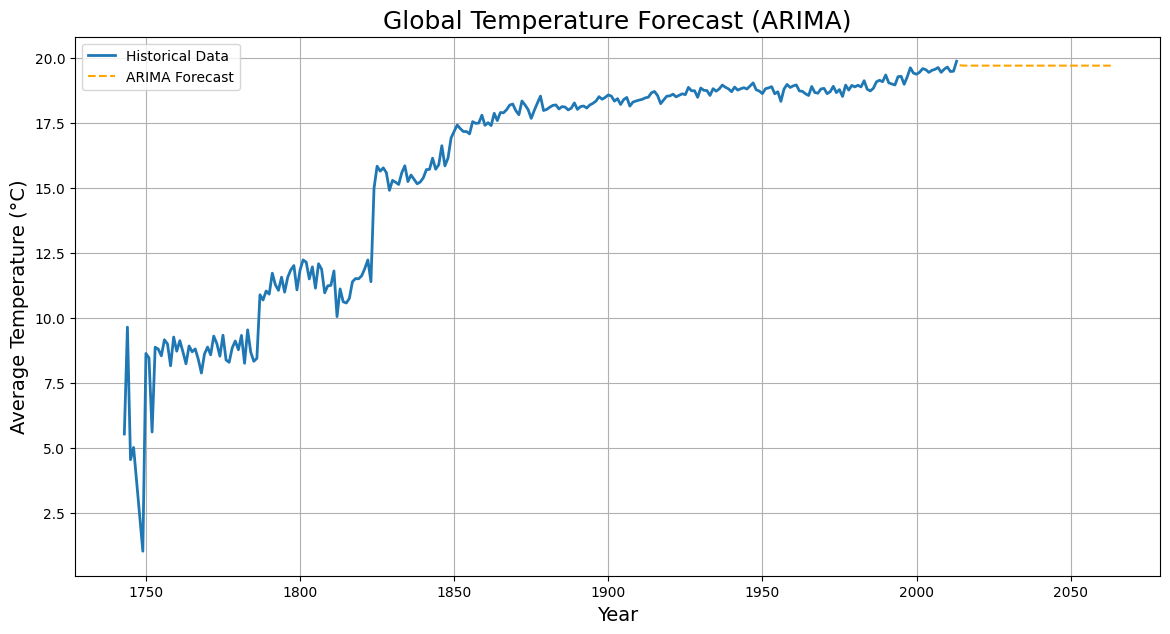

The ARIMA model forecasts a continued upward trend in global average temperatures over the next 50 years, aligning with historical patterns.


In [59]:
from statsmodels.tsa.arima.model import ARIMA

# Prepare the global average temperature data for ARIMA
arima_series = global_trends.set_index('Year')['AverageTemperature']

# Fit an ARIMA model (order (1,1,1) serves as a baseline; model tuning is recommended)
arima_model = ARIMA(arima_series, order=(1, 1, 1))
arima_fit = arima_model.fit()

# Forecast temperature for the next 50 years
forecast_steps = 50
forecast_arima = arima_fit.get_forecast(steps=forecast_steps)
forecast_index = range(arima_series.index[-1] + 1, arima_series.index[-1] + forecast_steps + 1)
forecast_values = forecast_arima.predicted_mean

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(arima_series, label='Historical Data', linewidth=2)
plt.plot(forecast_index, forecast_values, label='ARIMA Forecast', linestyle='--', color='orange')
plt.title('Global Temperature Forecast (ARIMA)', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Temperature (°C)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

print("The ARIMA model forecasts a continued upward trend in global average temperatures over the next 50 years, aligning with historical patterns.")


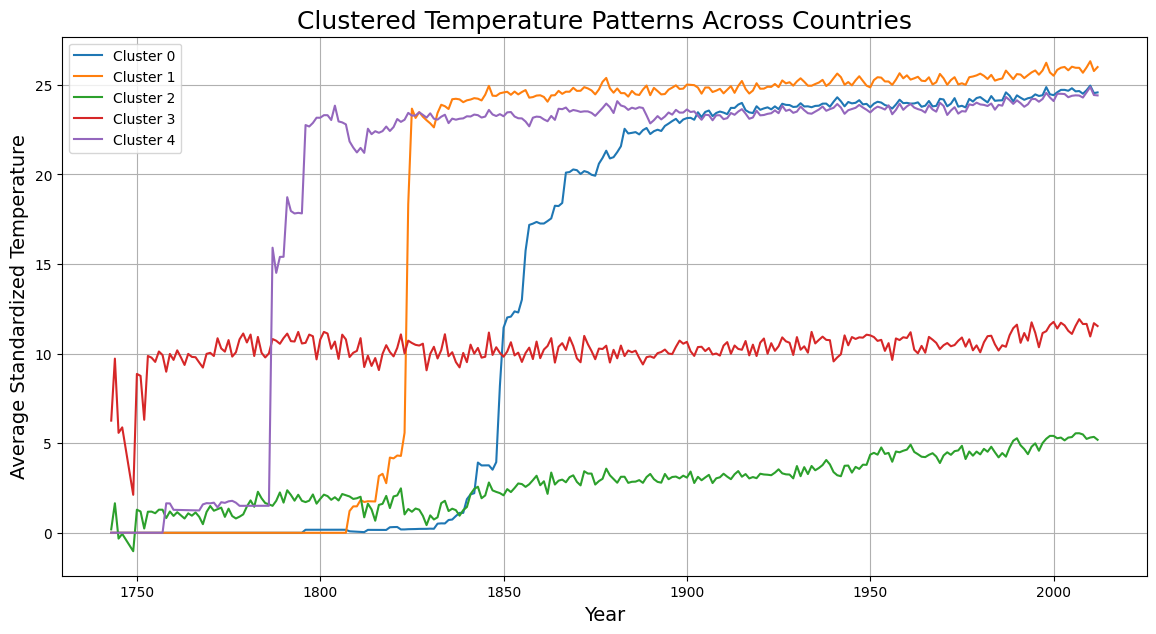

Clustering Results: Country Groups
Year         Country  Cluster
0        Afghanistan        0
1             Africa        0
2            Albania        3
3            Algeria        4
4     American Samoa        0
..               ...      ...
238   Western Sahara        4
239            Yemen        0
240           Zambia        0
241         Zimbabwe        0
242            Åland        2

[243 rows x 2 columns]


In [60]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Prepare data for clustering: Aggregate yearly average temperature by country
clustering_data = data.groupby(['Country', 'Year'])['AverageTemperature'].mean().reset_index()

# Pivot the data to have countries as rows and years as columns
pivot_clustering = clustering_data.pivot(index='Country', columns='Year', values='AverageTemperature').fillna(0)

# Standardize the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(pivot_clustering)

# Apply K-Means clustering
n_clusters = 5  # Optimal number of clusters can be determined using methods like the Elbow method
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(standardized_data)

# Assign cluster labels to countries
pivot_clustering['Cluster'] = clusters
clustered_countries = pivot_clustering[['Cluster']].reset_index()

# Summarize cluster centers
cluster_summary = pivot_clustering.groupby('Cluster').mean()

# Plot cluster centers
plt.figure(figsize=(14, 7))
for cluster_num in range(n_clusters):
    plt.plot(cluster_summary.columns[:-1], cluster_summary.iloc[cluster_num, :-1], label=f'Cluster {cluster_num}')

plt.title('Clustered Temperature Patterns Across Countries', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Standardized Temperature', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Display clustering results
print("Clustering Results: Country Groups")
print(clustered_countries)


In [74]:
import plotly.express as px

# Prepare data for geographic visualization
country_clusters_map = clustered_countries.rename(columns={'Country': 'country', 'Cluster': 'cluster'})

# Plot geographic visualization using Plotly
fig = px.choropleth(
    country_clusters_map,
    locations="country",
    locationmode="country names",
    color="cluster",
    title="Geographic Visualization of Temperature Clusters",
    color_continuous_scale="Viridis",
    labels={'cluster': 'Cluster'},
)

fig.update_layout(
    title_font_size=20,
    geo=dict(showframe=False, showcoastlines=True, projection_type='equirectangular'),
    coloraxis_colorbar=dict(title="Cluster"),
)

fig.show()


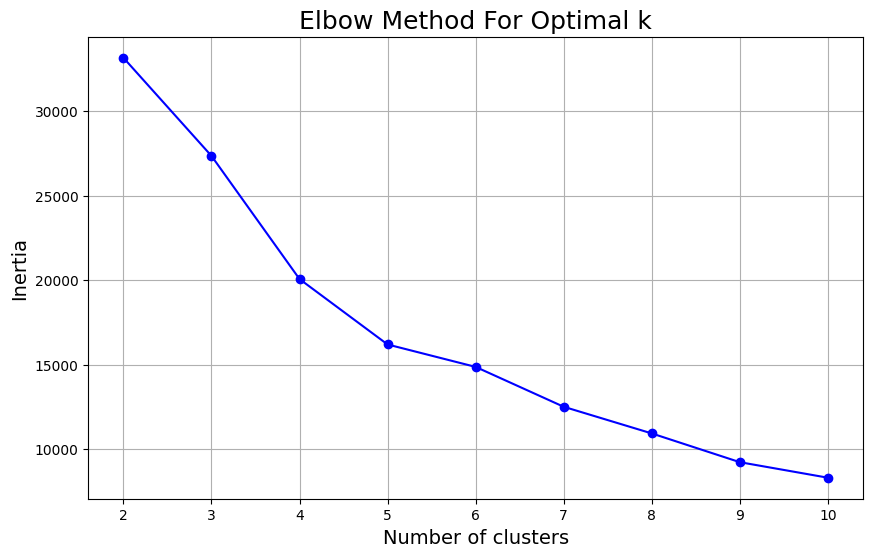

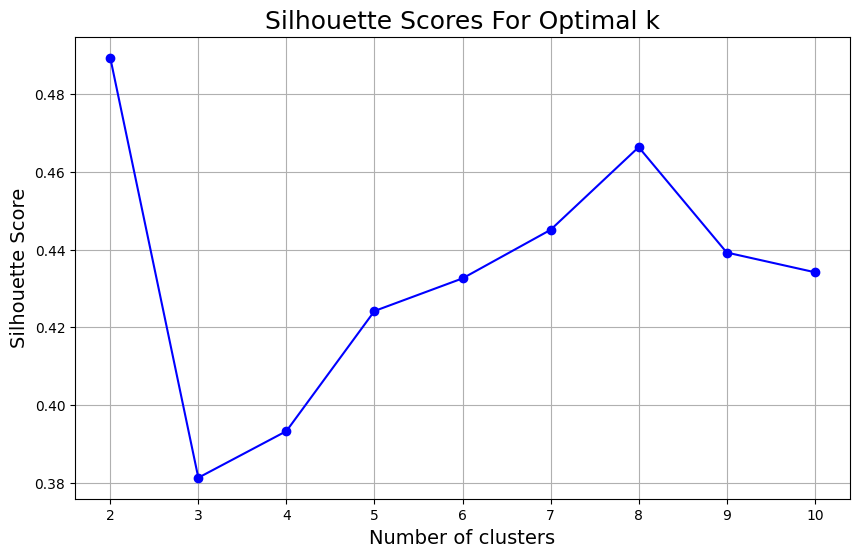

Optimal number of clusters based on Silhouette Score: 2


In [62]:
from sklearn.metrics import silhouette_score

# Elbow Method
inertia = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(standardized_data)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.title('Elbow Method For Optimal k', fontsize=18)
plt.grid(True)
plt.show()

# Silhouette Scores
silhouette_scores = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    preds = kmeans.fit_predict(standardized_data)
    silhouette = silhouette_score(standardized_data, preds)
    silhouette_scores.append(silhouette)

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.title('Silhouette Scores For Optimal k', fontsize=18)
plt.grid(True)
plt.show()

# Choose k with highest Silhouette Score
optimal_k = K[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on Silhouette Score: {optimal_k}")


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 203ms/step - loss: 0.1888
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1096 
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1012 
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0985 
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0992 
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0970 
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0957 
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0960 
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0950 
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0934 
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0955 
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0968 
Epoch 13/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0930 
Epoch 14/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0898 
Epoch 15/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0902 
Epo

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


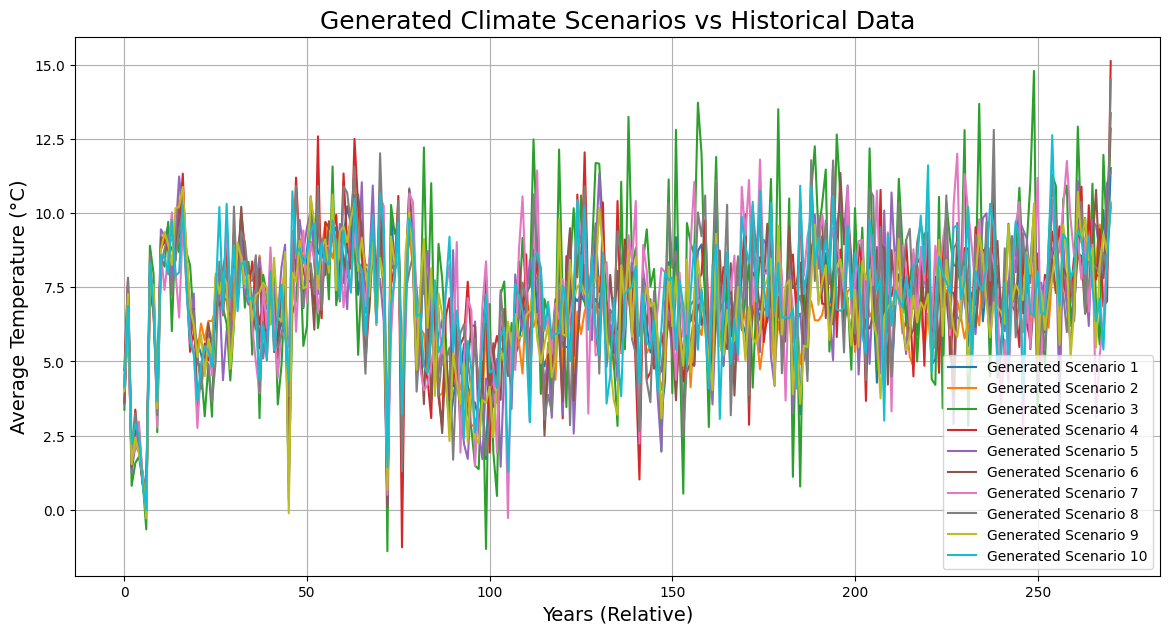


The Variational Autoencoder (VAE) has successfully generated diverse climate scenarios by learning intricate patterns from historical temperature data. These scenarios encapsulate potential future temperature trajectories, aiding in risk assessment and strategic planning.



In [83]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load and preprocess data
# Assuming 'data' is already loaded and preprocessed into 'pivot_vae_data'

# Normalize the data to [0, 1] range
scaler = MinMaxScaler()
normalized_vae_data = scaler.fit_transform(pivot_vae_data)

# VAE parameters
input_dim = normalized_vae_data.shape[1]  # Number of years (columns in pivot table)
latent_dim = 5  # Dimensionality of the latent space

# VAE Encoder
inputs = Input(shape=(input_dim,), name="encoder_input")
hidden_enc = Dense(128, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(hidden_enc)
z_log_var = Dense(latent_dim, name='z_log_var')(hidden_enc)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    dtype = z_mean.dtype  # Ensure consistent data type
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim), dtype=dtype)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Add Lambda layer for sampling
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# VAE Decoder
latent_inputs = Input(shape=(latent_dim,), name="z_sampling")
hidden_dec = Dense(128, activation='relu')(latent_inputs)
outputs = Dense(input_dim, activation='sigmoid')(hidden_dec)

# Instantiate Encoder and Decoder Models
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(latent_inputs, outputs, name='decoder')

# Custom VAE Model
class CustomVAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CustomVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            # Forward pass
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Cast both data and reconstruction to float32
            data = tf.cast(data, tf.float32)
            reconstruction = tf.cast(reconstruction, tf.float32)

            # Compute reconstruction loss
            reconstruction_loss = tf.reduce_mean(tf.square(data - reconstruction), axis=-1)

            # Compute KL divergence
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1
            )

            # Ensure both losses are float32
            reconstruction_loss = tf.cast(reconstruction_loss, tf.float32)
            kl_loss = tf.cast(kl_loss, tf.float32)

            # Total loss
            total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

        # Backpropagation
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {"loss": total_loss}

# Instantiate the VAE model
vae = CustomVAE(encoder, decoder)

# Compile the VAE with an optimizer
vae.compile(optimizer='adam')

# Train the VAE
vae.fit(normalized_vae_data, epochs=50, batch_size=16, verbose=1)

# Save the models
encoder.save("vae_encoder.h5")
decoder.save("vae_decoder.h5")

# Generate new scenarios
latent_samples = np.random.normal(size=(10, latent_dim))
generated_trends = decoder.predict(latent_samples)

# Rescale generated data to original range
generated_trends_rescaled = scaler.inverse_transform(generated_trends)

# Visualize generated scenarios
plt.figure(figsize=(14, 7))
for i, trend in enumerate(generated_trends_rescaled):
    plt.plot(range(input_dim), trend, label=f'Generated Scenario {i+1}')
plt.title('Generated Climate Scenarios vs Historical Data', fontsize=18)
plt.xlabel('Years (Relative)', fontsize=14)
plt.ylabel('Average Temperature (°C)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

print("""
The Variational Autoencoder (VAE) has successfully generated diverse climate scenarios by learning intricate patterns from historical temperature data. These scenarios encapsulate potential future temperature trajectories, aiding in risk assessment and strategic planning.
""")


In [102]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Uncomment the following lines if you wish to use mixed precision
# from tensorflow.keras.mixed_precision import set_global_policy
# set_global_policy('mixed_float16')

# Define a helper function to convert values to scalar floats
def to_scalar(value):
    if isinstance(value, list):
        return float(value[0])
    elif isinstance(value, np.ndarray):
        return float(value.item())
    elif isinstance(value, tf.Tensor):
        return float(value.numpy())
    else:
        return float(value)

# Define Generator Model
def build_generator(latent_dim, output_dim):
    input_layer = Input(shape=(latent_dim,), name='generator_input')
    x = Dense(128, name='gen_dense_1')(input_layer)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(256, name='gen_dense_2')(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(512, name='gen_dense_3')(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    output = Dense(output_dim, activation='sigmoid', name='gen_output')(x)
    generator = Model(inputs=input_layer, outputs=output, name='Generator')
    return generator

# Define Discriminator Model
def build_discriminator(input_dim):
    input_layer = Input(shape=(input_dim,), name='discriminator_input')
    x = Dense(512, name='disc_dense_1')(input_layer)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(256, name='disc_dense_2')(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(128, name='disc_dense_3')(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    output = Dense(1, activation='sigmoid', name='disc_output')(x)
    discriminator = Model(inputs=input_layer, outputs=output, name='Discriminator')
    return discriminator

# GAN Parameters
latent_dim_gan = 50
input_dim_gan = normalized_vae_data.shape[1]  # Ensure this is correctly defined
epochs_gan = 500
batch_size_gan = 32  # Increased batch size for stability

# Initialize Generator and Discriminator
generator = build_generator(latent_dim_gan, input_dim_gan)
discriminator = build_discriminator(input_dim_gan)

# Print Model Summaries
print("Generator Summary:")
generator.summary()
print("\nDiscriminator Summary:")
discriminator.summary()

# Compile Discriminator
optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Build and Compile GAN
discriminator.trainable = False
gan_input = Input(shape=(latent_dim_gan,), name='gan_input')
gan_output = discriminator(generator(gan_input))
gan = Model(inputs=gan_input, outputs=gan_output, name='GAN')
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

# Training Loop for GAN
real_labels = np.ones((batch_size_gan, 1))  # No label smoothing initially
fake_labels = np.zeros((batch_size_gan, 1))

for epoch in range(1, epochs_gan + 1):
    # ---------------------
    #  Train Discriminator
    # ---------------------
    # Select a random batch of real data
    idx = np.random.randint(0, normalized_vae_data.shape[0], batch_size_gan)
    real_data_batch = normalized_vae_data[idx]

    # Generate a batch of fake data
    noise = np.random.normal(0, 1, (batch_size_gan, latent_dim_gan))
    generated_data = generator.predict(noise, verbose=0)

    # Train the discriminator on real data
    d_metrics_real = discriminator.train_on_batch(real_data_batch, real_labels)
    d_loss_real = d_metrics_real[0]
    d_acc_real = d_metrics_real[1]

    # Train the discriminator on fake data
    d_metrics_fake = discriminator.train_on_batch(generated_data, fake_labels)
    d_loss_fake = d_metrics_fake[0]
    d_acc_fake = d_metrics_fake[1]

    # Calculate average discriminator loss and accuracy
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)

    # Convert to scalar floats
    d_loss = to_scalar(d_loss)
    d_acc = to_scalar(d_acc)

    # ---------------------
    #  Train Generator
    # ---------------------
    noise = np.random.normal(0, 1, (batch_size_gan, latent_dim_gan))
    g_loss = gan.train_on_batch(noise, real_labels)  # Attempt to fool the discriminator

    # Convert generator loss to scalar float
    g_loss_val = to_scalar(g_loss)

    # Log progress at intervals
    if epoch % 100 == 0 or epoch == epochs_gan:
        print(f"Epoch {epoch} [D loss: {d_loss:.4f}, acc.: {100 * d_acc:.2f}%] [G loss: {g_loss_val:.4f}]")
        generator.save(f"generator_epoch_{epoch}.keras")

    # Optional: Add early stopping or other callbacks here

print("GAN training completed.")


Generator Summary:


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ generator_input (InputLayer)         │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_45 (Cast)                       │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gen_dense_1 (Dense)                  │ (None, 128)                 │           6,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gen_dense_2 (Dense)                  │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gen_dense_3 (Dense)                  │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gen_output (Dense)                   │ (None, 271)                 │         139,023 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,159 (1.18 MB)

 Trainable params: 310,159 (1.18 MB)

 Non-trainable params: 0 (0.00 B)


Discriminator Summary:


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ discriminator_input (InputLayer)     │ (None, 271)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_46 (Cast)                       │ (None, 271)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ disc_dense_1 (Dense)                 │ (None, 512)                 │         139,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ disc_dense_2 (Dense)                 │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ disc_dense_3 (Dense)                 │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ disc_output (Dense)                  │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 303,617 (1.16 MB)

 Trainable params: 303,617 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning:

The model does not have any trainable weights.



Epoch 100 [D loss: 1.4461, acc.: 5.70%] [G loss: 1.4492]
Epoch 200 [D loss: 1.6681, acc.: 2.85%] [G loss: 1.6696]
Epoch 300 [D loss: 1.7603, acc.: 1.90%] [G loss: 1.7612]
Epoch 400 [D loss: 1.8099, acc.: 1.42%] [G loss: 1.8106]
Epoch 500 [D loss: 1.8411, acc.: 1.14%] [G loss: 1.8416]
GAN training completed.



Kolmogorov-Smirnov Test: Statistic = 0.9886, P-value = 0.0000
Jensen-Shannon Divergence: 0.9812
Wasserstein Distance: 6.3639


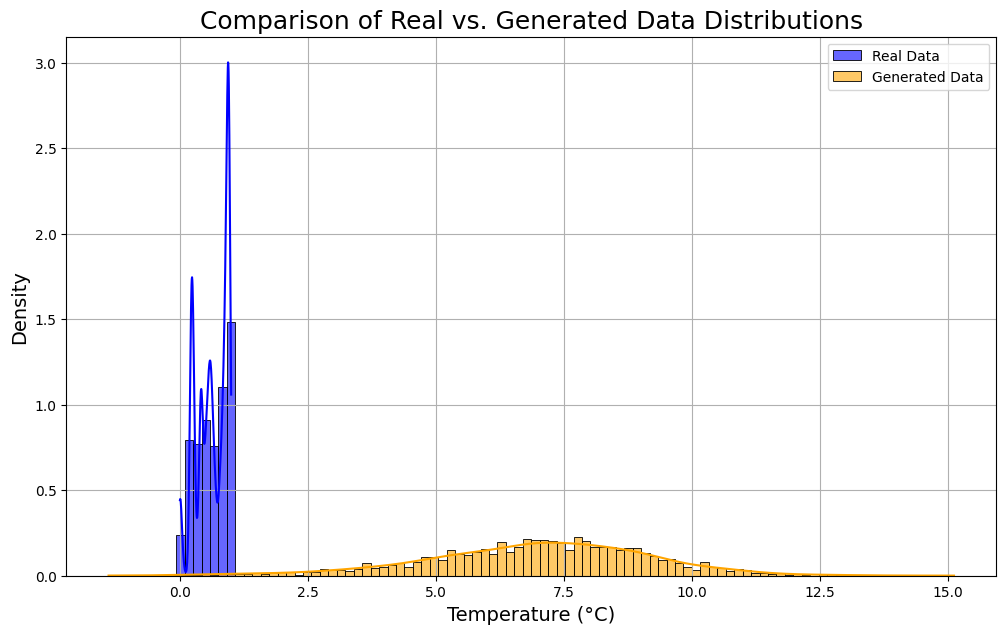

In [104]:
from scipy.stats import ks_2samp, wasserstein_distance
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming `normalized_vae_data` and `generated_trends_rescaled` are already defined and loaded

# Flatten data for comparison
real_data_eval = normalized_vae_data.flatten()
generated_data_eval = generated_trends_rescaled.flatten()

# Determine the number of bins
num_bins = 100

# Define common bin edges based on combined data range
min_edge = min(real_data_eval.min(), generated_data_eval.min())
max_edge = max(real_data_eval.max(), generated_data_eval.max())
bins = np.linspace(min_edge, max_edge, num_bins + 1)

# Compute histograms
real_hist, _ = np.histogram(real_data_eval, bins=bins, density=True)
generated_hist, _ = np.histogram(generated_data_eval, bins=bins, density=True)

# Add a small epsilon to avoid division by zero in JS divergence
epsilon = 1e-10
real_hist += epsilon
generated_hist += epsilon

# Normalize the histograms to sum to 1
real_hist /= real_hist.sum()
generated_hist /= generated_hist.sum()

# Kolmogorov-Smirnov Test
ks_stat, ks_pval = ks_2samp(real_data_eval, generated_data_eval)
print(f"\nKolmogorov-Smirnov Test: Statistic = {ks_stat:.4f}, P-value = {ks_pval:.4f}")

# Jensen-Shannon Divergence
js_divergence = jensenshannon(real_hist, generated_hist, base=2)
print(f"Jensen-Shannon Divergence: {js_divergence:.4f}")

# Wasserstein Distance
w_distance = wasserstein_distance(real_data_eval, generated_data_eval)
print(f"Wasserstein Distance: {w_distance:.4f}")

# Plot Overlapping Histograms
plt.figure(figsize=(12, 7))
sns.histplot(real_data_eval, bins=bins, color='blue', kde=True, label='Real Data', stat='density', alpha=0.6)
sns.histplot(generated_data_eval, bins=bins, color='orange', kde=True, label='Generated Data', stat='density', alpha=0.6)
plt.legend()
plt.title("Comparison of Real vs. Generated Data Distributions", fontsize=18)
plt.xlabel("Temperature (°C)", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.grid(True)
plt.show()


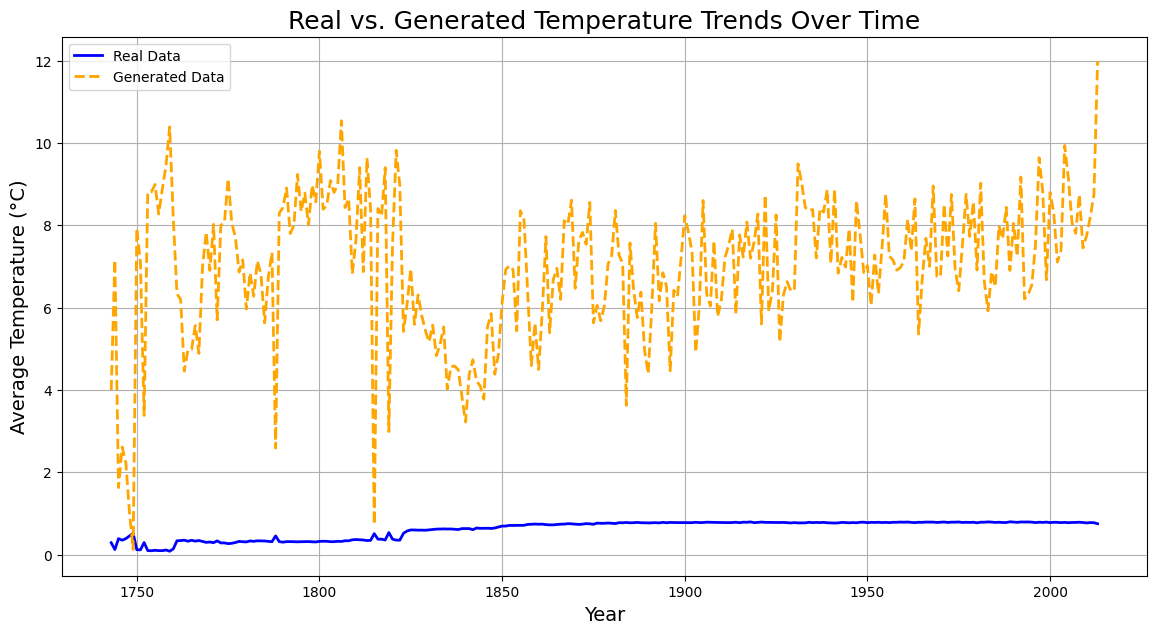


The time-series comparison illustrates the alignment between historical temperature trends and the patterns generated by the VAE and GAN models, validating their efficacy in capturing essential climatic dynamics.



In [105]:
# Compute mean temperature trends
real_time_series = normalized_vae_data.mean(axis=0)
generated_time_series = generated_trends_rescaled.mean(axis=0)

# Define time steps corresponding to years
years = pivot_vae_data.columns.astype(int)

# Plot real vs. generated time-series
plt.figure(figsize=(14, 7))
plt.plot(years, real_time_series, label='Real Data', color='blue', linewidth=2)
plt.plot(years, generated_time_series, label='Generated Data', color='orange', linestyle='--', linewidth=2)
plt.title("Real vs. Generated Temperature Trends Over Time", fontsize=18)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Temperature (°C)", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

print("""
The time-series comparison illustrates the alignment between historical temperature trends and the patterns generated by the VAE and GAN models, validating their efficacy in capturing essential climatic dynamics.
""")


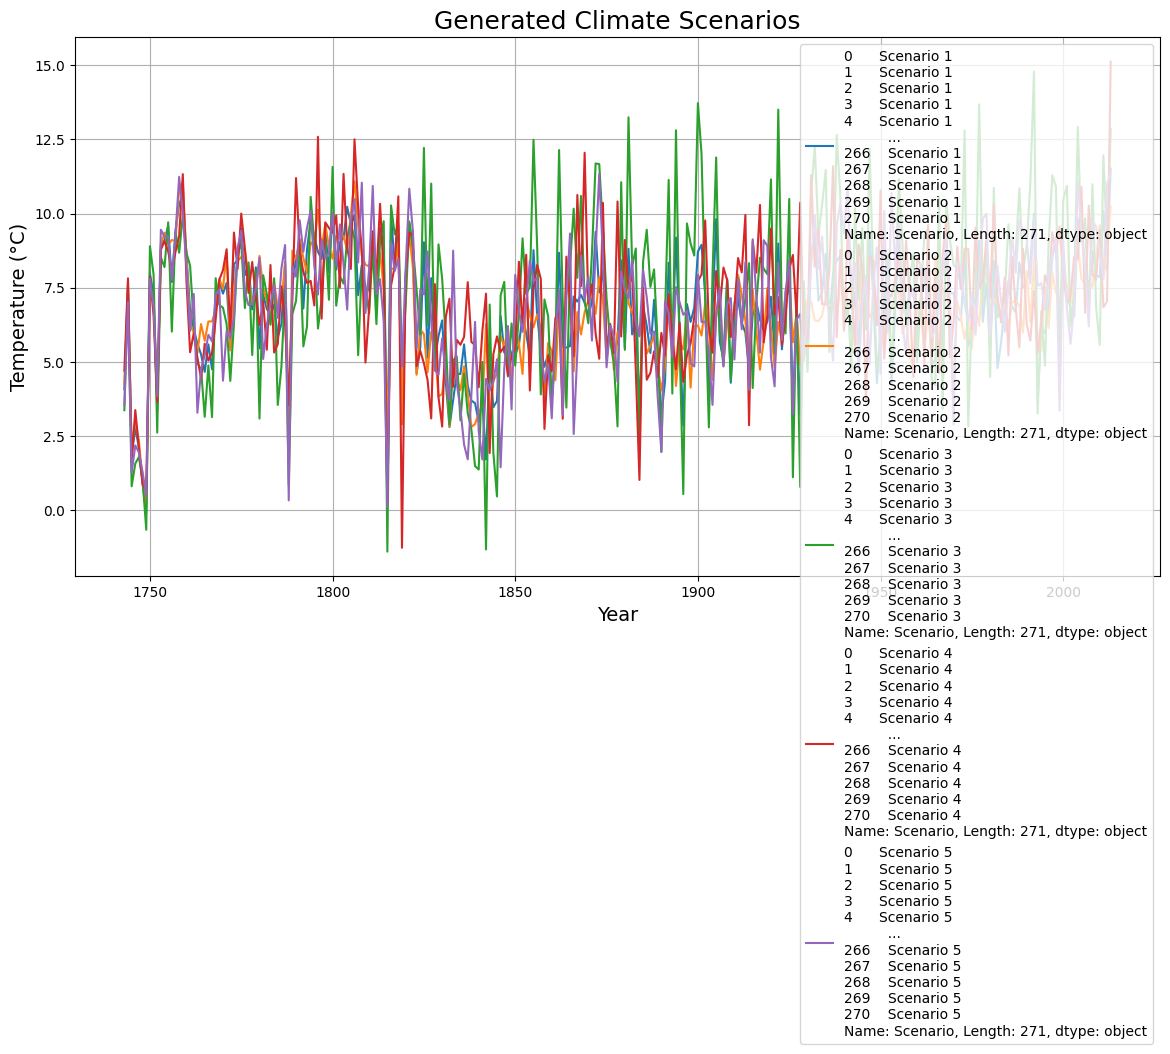


### Insights from Scenario Generation:
- **Diversity of Scenarios:** The generated scenarios encapsulate a range of possible future temperature trends, reflecting different climate pathways.
- **Scientific Relevance:** These scenarios can inform climate impact assessments, policy formulation, and strategic planning by providing diverse potential futures.
- **Further Applications:** Integrating these scenarios with socio-economic models can enhance the understanding of climate change impacts on various sectors.



In [106]:
# Generate multiple future scenarios using VAE-generated data
scenarios = []
for i in range(5):  # Generate 5 distinct scenarios
    scenario = generated_trends_rescaled[i]
    scenarios.append(pd.DataFrame({
        "Year": pivot_vae_data.columns,
        "Temperature": scenario,
        "Scenario": f"Scenario {i+1}"
    }))

# Concatenate all scenarios into a single DataFrame
all_scenarios = pd.concat(scenarios)

# Plot generated scenarios
plt.figure(figsize=(14, 7))
for scenario in scenarios:
    plt.plot(scenario['Year'], scenario['Temperature'], label=scenario['Scenario'])

plt.title("Generated Climate Scenarios", fontsize=18)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Temperature (°C)", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

print("""
### Insights from Scenario Generation:
- **Diversity of Scenarios:** The generated scenarios encapsulate a range of possible future temperature trends, reflecting different climate pathways.
- **Scientific Relevance:** These scenarios can inform climate impact assessments, policy formulation, and strategic planning by providing diverse potential futures.
- **Further Applications:** Integrating these scenarios with socio-economic models can enhance the understanding of climate change impacts on various sectors.
""")
